# 8.5 循环神经网络的从零开始实现
- **目录**
  - 8.5.1 独热编码
  - 8.5.2 初始化模型参数
  - 8.5.3 循环神经网络模型
  - 8.5.4 预测
  - 8.5.5 梯度裁剪
  - 8.5.6 训练

- 在本节中，我们将根据 8.4节中的描述，
从头开始基于循环神经网络实现字符级语言模型。
- 这样的模型将在H.G.Wells的时光机器数据集上训练。
- 和前面8.3节中介绍过的一样，
先读取数据集。

In [1]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [3]:
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [4]:
len(vocab.idx_to_token), vocab.idx_to_token

(28,
 ['<unk>',
  ' ',
  'e',
  't',
  'a',
  'i',
  'n',
  'o',
  's',
  'h',
  'r',
  'd',
  'l',
  'm',
  'u',
  'c',
  'f',
  'w',
  'g',
  'y',
  'p',
  'b',
  'v',
  'k',
  'x',
  'z',
  'j',
  'q'])

In [5]:
list(iter(train_iter))[0][0].shape,list(iter(train_iter))[0][0]

(torch.Size([32, 35]),
 tensor([[13,  4, 15,  ...,  4, 22,  2],
         [ 2,  1, 21,  ...,  1,  5,  6],
         [ 4,  6,  1,  ..., 12, 19,  4],
         ...,
         [10,  2, 10,  ..., 16,  7, 10],
         [12,  5,  6,  ...,  1,  2, 24],
         [ 5,  8, 13,  ...,  4,  3,  1]]))

In [6]:
len(list(iter(train_iter)))

8

In [7]:
## 每个batch有两个tensor，形状都为(32,35)
## 第一个是训练数据X，第二个是标签Y，标签Y保存X对应词元后面的一个词元
list(iter(train_iter))[0]

(tensor([[ 1, 17,  2,  ...,  1,  5,  3],
         [ 3,  1, 16,  ...,  2,  8,  1],
         [10,  1,  4,  ...,  8,  1,  2],
         ...,
         [ 8,  1,  4,  ...,  3,  1, 21],
         [ 4,  6,  8,  ...,  6, 11,  1],
         [20, 12,  4,  ...,  1, 14, 20]]),
 tensor([[17,  2, 12,  ...,  5,  3,  1],
         [ 1, 16, 12,  ...,  8,  1,  7],
         [ 1,  4,  8,  ...,  1,  2,  4],
         ...,
         [ 1,  4, 21,  ...,  1, 21, 14],
         [ 6,  8, 20,  ..., 11,  1,  6],
         [12,  4, 15,  ..., 14, 20,  1]]))

In [8]:
## 第一个小批量的X张量的形状
list(iter(train_iter))[0][0].shape

torch.Size([32, 35])

## 8.5.1 独热编码

- 回想一下，在`train_iter`中，每个词元都表示为一个**数字索引**，
将这些索引直接输入神经网络可能会使学习变得困难。
- 我们通常将每个词元表示为**更具表现力的特征向量**。最简单的表示称为**独热编码（one-hot encoding）**，它在 3.4.1节中介绍过。
- 简言之，将每个索引映射为相互不同的单位向量：
  - **假设词表中不同词元的数目为$N$（即`len(vocab)`），词元索引的范围为$0$到$N-1$。**
  - **如果词元的索引是整数$i$，那么我们将创建一个长度为$N$的全$0$向量，并将第$i$处的元素设置为$1$。**
  - 此向量是原始词元的一个独热向量。
- 索引为$0$和$2$的独热向量如下所示：


In [9]:
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

- 我们每次采样的小批量数据形状是二维张量：<b>（批量大小，时间步数）</b>。
- `one_hot`函数将这样一个小批量数据转换成三维张量，
张量的最后一个维度等于词表大小（`len(vocab)`）。
- 转换输入的维度，获得形状为 **（时间步数，批量大小，词表大小）** 的输出。
- 这将使我们能够更方便地通过最外层的维度，
一步一步地**更新小批量数据的隐状态**。


In [10]:
X = torch.arange(10).reshape((2, 5))
## 对X进行转置，将时间步维转换到第1维
F.one_hot(X.T, 28).shape,F.one_hot(X.T, 28)

(torch.Size([5, 2, 28]),
 tensor([[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0]],
 
         [[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0]],
 
         [[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0]],
 
         [[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0]],
 
         [[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0],


## 8.5.2 初始化模型参数

- 接下来，初始化循环神经网络模型的模型参数。
- 隐藏单元数`num_hiddens`是一个**可调**的超参数。
- 当训练语言模型时，输入和输出来自**相同的词表**，因此，它们具有相同的维度，即词表的大小。


In [11]:
## 设批量大小为32，时间步数为35，词表大小为28，隐层单元数为512
## 函数各变量的大小变换过程
def get_params(vocab_size, num_hiddens, device):
    ## 输入大小等于输出大小等于词表大小
    ## 后面运算结果的确如此，输出是(n,28)形状，n一般是一个批量中所有词元的个数
    ## 注意输入的第二维形状28表示词元在词表中索引的独热编码
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # 隐藏层参数
    ## W_xh:(28,512)
    W_xh = normal((num_inputs, num_hiddens))
    ## W_hh:(512,512)
    W_hh = normal((num_hiddens, num_hiddens))
    ## b_h:(512,)
    b_h = torch.zeros(num_hiddens, device=device)
    # 输出层参数
    ## W_hq:(512,28)
    W_hq = normal((num_hiddens, num_outputs))
    ## b_q:(28,)
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

## 8.5.3 循环神经网络模型

- 为了定义循环神经网络模型，
我们首先需要一个`init_rnn_state`函数在初始化时返回隐状态。
- 这个函数的返回是一个张量，张量全用0填充，
形状为（批量大小，隐藏单元数）。
- 在后面的章节中将会遇到隐状态包含多个变量的情况，而使用元组可以更容易地处理些。


In [12]:
##返回的隐状态的形状：(32,512),初始值为0
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

- 下面的`rnn`函数定义了如何在**一个时间步内**计算隐状态和输出。
- 循环神经网络模型通过`inputs`最外层的维度实现循环，以便逐时间步更新小批量数据的隐状态`H`。
- 此外，这里使用$\tanh$函数作为激活函数。
  - 如4.1节所述，当元素在实数上满足均匀分布时，$\tanh$函数的平均值为0。


In [13]:
def rnn(inputs, state, params):
    # inputs的形状：(时间步数量，批量大小，词表大小)
    '''
    尤其要注意inputs的形状，时间步数量在前，批量大小在后。
    本例是(35,32,28),其本意应该是从时间步上对小批量里数据进行处理。
    W_xh, W_hh, b_h, W_hq, b_q形状分别为：
    (28,512),(512,512),(512,),(512,28),(28,)
    H的形状为:(32,512)
    '''
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    
    # X的形状：(批量大小，词表大小)
    '''
    inputs的形状为(35,32,28),
    那么每次迭代的X的形状为(32,28)。迭代次数为35，在时间步数（窗口大小）上进行迭代。
    下面计算过程：
    （1） H的形状为(32,512)，过程分解如下：
            torch.mm(X, W_xh)=(32,28)@(28,512)=(32,512)
            torch.mm(H, W_hh)=(32,512)@(512,512)=(32,512)
            b_h=(512)
            然后求3个张量的和，形状为：(32,512)
    （2） Y的形状为(32,28)，过程分解如下：
            torch.mm(H, W_hq)=(32,512)@(512,28)=(32,28)
            b_h形状为(28,)
            上述两个张量求和:(32,28)
    （3） outputs的形状(1120,28)：
            outputs.append(Y)迭代35次，因此outputs里保存了35个形状为(32,28)的张量。
            在return里对这35个张量在0轴上（垂直方向）进行连接，
            最后形成(35*32,28)，即(1120,28)的返回结果。  
            是1120个词元索引的独热编码。
    注意激活函数是tanh，而不是relu等。
    '''
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h) # 上述注释中的（1）
        Y = torch.mm(H, W_hq) + b_q # 上述注释中的（2）
        outputs.append(Y)
    ## 在垂直方向对行进行连接
    ## 上述注释中的（3）所说明
    ## 隐状态是非常重要的参数，直接关系到后面的推理
    return torch.cat(outputs, dim=0), (H,)

- 定义了所有需要的函数之后，接下来我们创建一个类来包装这些函数，并存储从零开始实现的循环神经网络模型的参数。


In [14]:
## 这个类的功能基本上就是前面两个函数功能的整合
## 除了增加了一个独热编码功能
class RNNModelScratch: #@save
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        ##注意：初始化时，需要将forward_fn赋值为前面定义的rnn函数
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        '''
        此处将输入数据进行独热编码。注意此处将X转置，是为了将小批量与时间步数的维度对调。
        比如前文中的(32,35,28)变成(35,32,28)。
        '''
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

- 检查输出是否具有正确的形状？
  - 例如，隐状态的维数是否保持不变。


In [15]:
##使用上面定义的X,形状为(2,5)
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params, init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

- 可以看到输出形状是 **（时间步数$\times$批量大小，词表大小）**，而**隐状态形状保持不变，即（批量大小，隐藏单元数）**。

## 8.5.4 预测

- 首先定义预测函数来生成`prefix`之后的新字符，其中的`prefix`是一个**用户提供**的包含多个字符的字符串。
- 在循环遍历`prefix`中的开始字符时，我们**不断地将隐状态传递到下一个时间步，但是不生成任何输出**。
- 这被称为**预热（warm-up）期**，因为在此期间模型会自我更新（例如，更新隐状态），但不会进行预测。
- **预热期结束后，隐状态的值通常比刚开始的初始值更适合预测，**
从而预测字符并输出它们。

In [16]:
def predict_ch8(prefix, num_preds, net, vocab, device):  #@save
    """在prefix后面生成新字符"""
    ## 隐状态的初始值为0，形状为(1,512),1是批量大小，此处是被显式赋值。
    ## 512隐藏层单元的个数。都是8的倍数
    state = net.begin_state(batch_size=1, device=device)
    ## 取出前缀的第一个字符的索引
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:  # 预热期
        ##在模型里计算隐状态
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # 预测num_preds步
        ##此处的state是经过预热后的隐状态值
        ##也就是前面讲的：预热结束后，隐状态更适合预测
        y, state = net(get_input(), state)
        ##将预测的词元索引存放到添加到outputs里
        ##注意y是(n,28)形状，每一行是索引独热编码
        ##因此要通过argmax函数取出每行中的'1'所在索引就是词元在词表中的索引
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [17]:
##前缀第一个字母('t')的索引
prefix='time traveller '
vocab[prefix[0]]

3

In [18]:
## 注意从独热编码中提取词元索引的形状：从二维变成一维
a = torch.zeros((1,28,1))
a[:,12,:]=1
i = a.argmax(dim=1)
i, i.reshape(1), a

(tensor([[12]]),
 tensor([12]),
 tensor([[[0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [1.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.]]]))

- 现在可以测试`predict_ch8`函数。
- 将前缀指定为`time traveller `，并基于这个前缀生成10个后续字符。
- 鉴于还没有训练网络，它会生成荒谬的预测结果。


In [19]:
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller teinchrubk'

## 8.5.5 梯度裁剪

对于长度为$T$的序列，我们在迭代中计算这$T$个时间步上的梯度，
将会在反向传播过程中产生长度为$\mathcal{O}(T)$的矩阵乘法链。
如 4.8节所述，
**当$T$较大时，它可能导致数值不稳定**，
例如可能导致梯度爆炸或梯度消失。因此，循环神经网络模型往往需要额外的方式来支持稳定训练。
一般来说，当解决优化问题时，我们对模型参数采用更新步骤。
例如，使用$\eta > 0$作为学习率时，在一次迭代中，
我们将$\mathbf{x}$更新为$\mathbf{x} - \eta \mathbf{g}$。
如果我们进一步假设目标函数$f$表现良好，
即函数$f$在常数$L$下是**利普希茨连续的（Lipschitz continuous）**。该连续性是度量空间中的函数性质之一，用来描述函数变化的“速度”或“平滑性”。如果一个函数满足 Lipschitz 连续性条件，它意味着函数的变化不会比输入的变化快得多，即输入的微小变化不会导致函数值发生剧烈变化。

对于任意$\mathbf{x}$和$\mathbf{y}$我们有：

$$|f(\mathbf{x}) - f(\mathbf{y})| \leq L \|\mathbf{x} - \mathbf{y}\| \tag{8.5.1}$$

在这种情况下，我们可以安全地假设：
如果我们通过$\eta \mathbf{g}$更新参数向量，则

$$|f(\mathbf{x}) - f(\mathbf{x} - \eta\mathbf{g})| \leq L \eta\|\mathbf{g}\|\tag{8.5.2}$$

这意味着我们不会观察到超过$L \eta \|\mathbf{g}\|$的变化。
这既是坏事也是好事。
坏的方面，它限制了取得进展的速度；
好的方面，它限制了事情变糟的程度，尤其当我们朝着错误的方向前进时。

有时梯度可能很大，从而优化算法可能无法收敛。
我们可以通过降低$\eta$的学习率来解决这个问题。
但是如果我们很少得到大的梯度呢？
在这种情况下，这种做法似乎毫无道理。
一个流行的替代方案是通过将梯度$\mathbf{g}$投影回给定半径
（例如$\theta$）的球来裁剪梯度$\mathbf{g}$。
如下式：

$$\mathbf{g} \leftarrow \min\left(1, \frac{\theta}{\|\mathbf{g}\|}\right) \mathbf{g} \tag{8.5.3}$$

通过这样做，我们知道**梯度范数永远不会超过$\theta$，
并且更新后的梯度完全与$\mathbf{g}$的原始方向对齐。**
它还有一个值得拥有的副作用，
即**限制任何给定的小批量数据（以及其中任何给定的样本）对参数向量的影响**，
这赋予了模型一定程度的稳定性。
梯度裁剪提供了一个快速修复梯度爆炸的方法，
虽然它并不能完全解决问题，但它是众多有效的技术之一。

下面我们定义一个函数来裁剪模型的梯度，
模型是从零开始实现的模型或由高级API构建的模型。
我们在此计算了所有模型参数的梯度的范数。

- **要点：**
  - 对于循环神经网络模型，当序列长度较大时，梯度计算会产生长度为$O(T)$的矩阵乘法链，可能导致数值不稳定，如梯度爆炸或梯度消失的问题。
  - 在优化问题中，通过更新模型参数来解决问题，例如使用学习率乘以负梯度来更新参数。
  - 如果目标函数是利普希茨连续的，即满足Lipschitz连续性条件，可以安全地假设更新参数后的函数值变化不会超过$L\eta∥g∥$，其中$L$是常数，$\eta$是学习率，$g$是梯度向量。
  - 当梯度较大导致优化算法难以收敛时，可以降低学习率。但如果梯度很少大于阈值呢？这种情况下，降低学习率可能不合理。
  - 梯度裁剪是一种解决梯度爆炸问题的常用方法。它通过将梯度投影到给定半径（例如$\theta$）的球上来裁剪梯度。裁剪后的梯度范数不会超过$\theta$，而且梯度方向与原始梯度方向保持一致。
  - 梯度裁剪的副作用之一是限制了小批量数据对参数的影响，从而提高模型的稳定性。
  - 梯度裁剪是一种快速修复梯度爆炸问题的方法，虽然不能完全解决问题，但是是有效的技术之一。

In [20]:
##这个算法好理解，求梯度的平方和的平方根，即l2范数
## 然后用每个梯度除以该范数即可。
def grad_clipping(net, theta):  #@save
    """裁剪梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            ##:符号的作用，保证grad的运算是就地操作
            param.grad[:] *= theta / norm
            

## 8.5.6 训练

在训练模型之前，让我们定义一个函数在一个迭代周期内训练模型。
它与我们训练 3.6节模型的方式有三个不同之处：

1. 序列数据的不同采样方法（**随机采样和顺序分区**）将导致隐状态初始化的差异。
1. 我们在更新模型参数之前裁剪梯度。
   这样的操作的目的是：**即使训练过程中某个点上发生了梯度爆炸，也能保证模型不会发散**。
1. 我们用困惑度来评价模型。如 8.4.4节所述，
   这样的度量确保了不同长度的序列具有可比性。

具体来说，当使用顺序分区时，
我们只在**每个迭代周期的开始位置初始化隐状态**。
由于下一个小批量数据中的第$i$个子序列样本
与当前第$i$个子序列样本相邻，
因此**当前小批量数据最后一个样本的隐状态，
将用于初始化下一个小批量数据第一个样本的隐状态**。
这样，存储在隐状态中的序列的历史信息
可以在**一个迭代周期内流经相邻的子序列**。
然而，在任何一点隐状态的计算，
都依赖于同一迭代周期中前面所有的小批量数据，
这使得梯度计算变得**复杂**。
**为了降低计算量，在处理任何一个小批量数据之前，
我们先分离梯度，使得隐状态的梯度计算总是限制在一个小批量数据的时间步内。**

**当使用随机抽样时，因为每个样本都是在一个随机位置抽样的，
因此需要为每个迭代周期重新初始化隐状态。**
与3.6节中的
`train_epoch_ch3`函数相同，
`updater`是更新模型参数的常用函数。
它既可以是从头开始实现的`d2l.sgd`函数，
也可以是深度学习框架中内置的优化函数。

- **要点：**
  - 在一个迭代周期内训练循环神经网络模型时，与3.6节中的方式相比，有三个不同之处：序列数据的采样方法、梯度裁剪和使用困惑度评价模型。
  - 使用不同的采样方法（随机采样和顺序分区）会导致隐状态初始化方式的差异。
  - 在顺序分区采样中，**仅在每个迭代周期的开始位置初始化隐状态**。当前小批量数据的最后一个样本的隐状态会用于初始化下一个小批量数据的第一个样本的隐状态，以便序列的历史信息能够在迭代周期内流经相邻的子序列。
  - 在随机抽样中，每个样本都是在随机位置抽样的，因此需要**为每个批量迭代之初重新初始化隐状态**。
  - 在更新模型参数之前进行梯度裁剪的目的是**防止梯度爆炸**，确保模型不会发散。
  - 使用困惑度作为评价模型的度量，确保不同长度的序列具有可比性。
  - 为了降低计算量，在处理任何一个小批量数据之前，先分离梯度，使得隐状态的梯度计算**限制在一个小批量**数据的时间步内。
  - `updater`是用于更新模型参数的常用函数，可以是自己实现的优化函数（如`d2l.sgd`），也可以是深度学习框架中内置的优化函数。

In [21]:
#@save
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练神经网络模型一个迭代周期"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和,词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化state
            ##由于随机抽样的序列数据无需在整个语料库中传递和共享隐状态，所以每次批量迭代时对隐状态初始化为0即可
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            '''
            如果是顺序分区的小批量，每个批量都要将隐状态的梯度进行分离。
            因为顺序分区的隐状态是跨批量共享的，但是参数更新以及梯度计算则是以批量为单位的，
            所以每个批量开始训练前需要将前一个批量的state从计算图中分离，
            然后只在本次批量中进行梯度计算和参数更新。            
            '''
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                state.detach_()
            else:
                # state对于nn.LSTM是tuple，有两个参数(H,C)
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            ## 每次在反向传播计算梯度时，需要对梯度清零
            updater.zero_grad()
            l.backward()
            ## 修剪梯度
            grad_clipping(net, 1)
            ## 更新参数
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调用了mean函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [1]:
import numpy as np
n = np.array([['B','C','D','E'],['I','J','K','L']])
n,n.T,n.T.reshape(-1)

(array([['B', 'C', 'D', 'E'],
        ['I', 'J', 'K', 'L']], dtype='<U1'),
 array([['B', 'I'],
        ['C', 'J'],
        ['D', 'K'],
        ['E', 'L']], dtype='<U1'),
 array(['B', 'I', 'C', 'J', 'D', 'K', 'E', 'L'], dtype='<U1'))

- 循环神经网络模型的训练函数既支持从零开始实现，也可以使用高级API来实现。


In [22]:
#@save
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

- 现在训练循环神经网络模型。
- 因为数据集中只使用了10000个词元，所以模型需要更多的迭代周期来更好地收敛。


困惑度 1.0, 38454.8 词元/秒 cuda:0
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


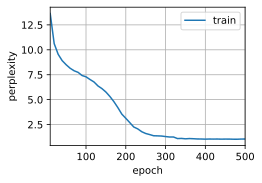

In [23]:
## 自定义的模型进行训练和预测。
## 顺序抽样的方法来训练模型
num_epochs, lr = 500, 1
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

In [24]:
net.params[0].shape,net.params[1].shape,net.params[2].shape,net.params[3].shape,net.params[4].shape

(torch.Size([28, 512]),
 torch.Size([512, 512]),
 torch.Size([512]),
 torch.Size([512, 28]),
 torch.Size([28]))

- 最后检查一下使用**随机抽样方法**的结果。


困惑度 1.6, 36045.1 词元/秒 cuda:0
time traveller proceeded anyreal body must have extension in fou
traveller brther had his sour chairs being his gatention or


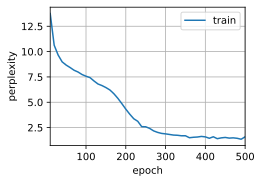

In [25]:
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)

- 从零开始实现上述循环神经网络模型，虽然有指导意义，但是并不方便。
- 下一节将学习如何改进循环神经网络模型。
  - 例如，如何使其实现地更容易，且运行速度更快。

## 小结

* 我们可以训练一个基于循环神经网络的**字符级语言模型**，根据用户提供的文本的前缀生成后续文本。
* 一个简单的循环神经网络语言模型包括输入编码、循环神经网络模型和输出生成。
* 循环神经网络模型在训练以前需要初始化状态，不过随机抽样和顺序分区使用初始化方法不同。
* 当使用顺序分区时，我们需要**分离梯度**以减少计算量。
* 在进行任何预测之前，模型通过**预热期**进行自我更新（例如，获得比初始值更好的隐状态）。
* 梯度裁剪可以防止梯度爆炸，但不能应对梯度消失。

------------------------

- **说明：detach()与deatch_()函数的区别与联系**
  - 当我们再训练网络的时候可能希望保持一部分的网络参数不变，只对其中一部分的参数进行调整；
  - 或者只训练部分分支网络，并不让其梯度对主网络的梯度造成影响，这时候我们就需要使用detach()函数来切断一些分支的反向传播。
   - detach(): detach()函数创建一个新的Tensor，该Tensor与原始Tensor共享相同的底层数据，但是不再与计算图相关联。换句话说，detach()返回一个不可求导的Tensor副本。这意味着在使用detach()分离的Tensor进行操作时，无法对其进行自动微分，也不会影响原始Tensor的梯度计算。
    - detach_(): detach_()函数是一个原地操作（in-place operation），它会直接修改原始Tensor，并将其从计算图中分离。与detach()不同，detach_()没有返回值，而是直接修改了原始Tensor。同样，这意味着对使用detach_()分离的Tensor进行操作时，无法对其进行自动微分，并且不会影响原始Tensor的梯度计算。

In [23]:
import torch

# 创建一个张量
x = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)

# 进行一些操作
y = x ** 2
z = y + 2

# 使用 detach()
w = z.detach()  # 将张量 z 从计算图中分离
print("分离的张量 w:", w)
print("是否需要梯度 (w):", w.requires_grad)  # False

print("detach()分离的张量 z:", z)
print("是否需要梯度 (z):", z.requires_grad)  # True
loss = z.mean()
print("损失值:", loss)

# detach()可以进行反向传播
loss.backward()

# 使用 detach_()从计算图中就地分离张量 z 
z.detach_()  
print("detach_()分离的张量 z:", z)
print("是否需要梯度 (z):", z.requires_grad)  # False

# 进行更多操作
loss = z.mean()
print("损失值:", loss)

# 进行反向传播，此时会发生异常
loss.backward()

# 检查梯度：由于前文发生异常，已经无法显示梯度
print("梯度 (x):", x.grad)  # 具有梯度的张量


分离的张量 w: tensor([ 3.,  6., 11.])
是否需要梯度 (w): False
detach()分离的张量 z: tensor([ 3.,  6., 11.], grad_fn=<AddBackward0>)
是否需要梯度 (z): True
损失值: tensor(6.6667, grad_fn=<MeanBackward0>)
detach_()分离的张量 z: tensor([ 3.,  6., 11.])
是否需要梯度 (z): False
损失值: tensor(6.6667)


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

---------------